In [1]:
import pickle

from collections import defaultdict, OrderedDict
from copy import deepcopy

from geoloc_imc_2023.query_api import get_measurements_from_tag
from geoloc_imc_2023.default import ANCHOR_TARGET_PROBE_VP
from geoloc_imc_2023.measurement_utils import load_atlas_anchors, load_atlas_probes
from geoloc_imc_2023.helpers import distance, rtt_to_km

ModuleNotFoundError: No module named 'geoloc_imc_2023'

## load results

In [3]:
uuids = [
    "9b2dcfb5-1fde-4b95-810b-ada4d1277d48",
    "8ac19a02-d964-4aef-b233-d272d0d08669",
]

measurement_results = {}
for uuid in uuids:
    measurement_result = get_measurements_from_tag(uuid)
    measurement_results.update(measurement_result)

with open(ANCHOR_TARGET_PROBE_VP,"wb") as f:
    pickle.dump(measurement_results, f)

with open("../data/anchor_target_probe_vp_raw.pickle","wb") as f:
    pickle.dump(measurement_results, f)

In [ ]:
test = {}

t = {"a": 2, 'b': 3}
test.update(t)

## parse raw results

In [34]:
target_dataset = load_atlas_anchors()
vp_dataset = load_atlas_probes()

# check, for each target that they belong to target dataset, do the same for vps
with open("../data/anchor_target_probe_vp_raw.pickle", "rb") as f:
    measurement_results = pickle.load(f)

print(f"number of targets measurements: {len(measurement_results)}")


number of targets measurements: 780


In [37]:
filtered_results = deepcopy(measurement_results)
for i, target_addr in enumerate(measurement_results):
    # check target addr
    try:
        target_description = target_dataset[target_addr]
    except KeyError:
        print("target not part of target dataset, removing")
        filtered_results.pop(target_addr)
        continue
    
    # check that number of measurements is sufficient
    nb_measurements = len(measurement_results[target_addr])
    if nb_measurements < 9_000:
        filtered_results.pop(target_addr)
        continue
        
    # check vp addr
    for i, vp_addr in enumerate(measurement_results[target_addr]):
        try:
            vp_description = vp_dataset[vp_addr]
        except KeyError:
            filtered_results[target_addr].pop(vp_addr)
    


In [39]:
with open(ANCHOR_TARGET_PROBE_VP,"wb") as f:
    pickle.dump(filtered_results, f)

## validate vps geoloc

In [2]:
target_dataset = load_atlas_anchors()
vp_dataset = load_atlas_probes()

# check, for each target that they belong to target dataset, do the same for vps
with open(ANCHOR_TARGET_PROBE_VP, "rb") as f:
    measurement_results = pickle.load(f)


In [3]:
filtered_results = deepcopy(measurement_results)
geoloc_disputed = defaultdict(list)
for i, target_addr in enumerate(measurement_results):

    # get target addr geolocation
    target_description = target_dataset[target_addr]

    for vp_addr in measurement_results[target_addr]:

        # get vp geolocation
        vp_description = vp_dataset[vp_addr]

        # get distance from metadata
        theoretical_distance = distance(
            target_description["latitude"],
            vp_description["latitude"],
            target_description["longitude"],
            vp_description["longitude"],
        )

        # get distance from measurements
        measured_distance = rtt_to_km(measurement_results[target_addr][vp_addr]["min_rtt"])

        # light velocity violation condition
        if measured_distance > theoretical_distance:
            geoloc_disputed[vp_addr].append({
                "target": target_addr,
                "theoretical_distance": theoretical_distance,
                "measured_distance": measured_distance
            })
    

print(f"probe with geoloc disputed: {len(geoloc_disputed)}")


probe with geoloc disputed: 9066


In [4]:
geoloc_disputed = OrderedDict(
    {
        vp_addr : geoloc_disputed_list
        for vp_addr, geoloc_disputed_list 
        in sorted(geoloc_disputed.items(), key = lambda item: len(item[1]), reverse = True)
    }
)

test = []
for vp_addr, geoloc_disputed_list in geoloc_disputed.items():
    print(f"geoloc disputed candidate: {vp_addr} : {len(geoloc_disputed_list)}")
    test.append(len(geoloc_disputed_list))

        

geoloc disputed candidate: 193.37.151.128 : 763
geoloc disputed candidate: 85.76.115.196 : 763
geoloc disputed candidate: 89.101.70.74 : 763
geoloc disputed candidate: 84.15.212.76 : 763
geoloc disputed candidate: 84.214.210.15 : 763
geoloc disputed candidate: 89.43.185.123 : 763
geoloc disputed candidate: 80.109.231.130 : 763
geoloc disputed candidate: 46.15.94.214 : 763
geoloc disputed candidate: 79.97.114.234 : 763
geoloc disputed candidate: 141.22.28.253 : 763
geoloc disputed candidate: 157.25.223.78 : 763
geoloc disputed candidate: 83.8.142.64 : 763
geoloc disputed candidate: 80.235.226.218 : 763
geoloc disputed candidate: 85.89.171.241 : 763
geoloc disputed candidate: 178.235.129.15 : 763
geoloc disputed candidate: 79.212.37.250 : 763
geoloc disputed candidate: 188.141.10.47 : 763
geoloc disputed candidate: 193.105.105.194 : 763
geoloc disputed candidate: 212.46.64.36 : 763
geoloc disputed candidate: 90.35.64.22 : 763
geoloc disputed candidate: 178.118.131.117 : 763
geoloc disput

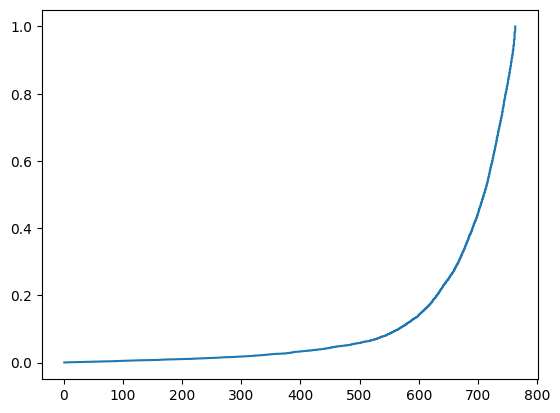

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def ecdf(data, array: bool=True):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)
    # x-data for the ECDF: x
    x = np.sort(data)
    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n
    if not array:
        return pd.DataFrame({'x': x, 'y': y})
    else:
        return x, y
    

fig, ax = plt.subplots()
        
x,y = ecdf(test)
ax.plot(x,y)